<a href="https://colab.research.google.com/github/Areeb297/Potential-Talents-Human-Resources-Staffing---Apziva-Project/blob/main/Portential_Talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Project Summary**

A talent sourcing and management company requires automating the process of identifying and ranking the best candidates for various roles where the current manual process is challenging and labor-intensive. The key challenges the company faces are:

1. Understanding the role: Accurately interpreting client's needs and expectations for potential candidates

2. Evaluating Candidates: Determining what makes a candidate suitable for a given role.

3. Sourcing talent: Finding qualified individuals from a large pool of candidates.

To address, the aim of this project is to develop a ML-powered pipeline that automates candidate ranking based on their "fitness" for a specific role. Additionally, this system should adaptively ren-rank candidates based on the human reviewer initial seletion such that the model re-ranks the list to better align with the reviewer's preferences, considering the starred candidate as the most important for this particular role. This will imporove the rankings generated by system over time.

#### **Key Requirements:**

* Fitness prediction
* Ranking
* Re-ranking
* Mitigate Human Bias in the process
* Filtering

### **Data Description:**

The dataset contains anonymized candidate information sourced through the company's semi-automated process and sourcing efforts.

Attributes:

1. id: Unique numeric identifier for each candidate
2. job_title: Text description of the candidate's job title.
3. location: Geographical location of the candidate.
4. connections: Number of professional connections the candidate has (e.g., 500+ indicates more than 500 connections).
5. fit: Target variable indicating the candidate's fitness score (numeric probability between 0 and 1). We can use cosine-similarity for this.

Currently, the fit column is empty so we need to NLP techniques such as TF-IDF, Word2Vec, Bert, Open source LLMs etc to match our search with job_title, location, and connections (the more the connections, the better it is as it is considered an added benefit).

### **Keywords:**
The data is based on searching specifc keywords for roles:
1. Aspiring human resources
2. Seeking human resources

### **Goals & Objective:**
1. Build a predictive model to calculate fitness score for each candidate based on given query.
2. Use fitness scores to rank candidates for specific roles.
3. Enable re-rankding based on manual feedback (starring action).
4. Identify methods to filter out candidates which in the first place should not be in this list?
5. Define an adaptive cut-off point that would work for other roles to exclude low-potential candidates while retaining high-potential ones.


The objective is to develop an intelligent candidate ranking system to ensure best and most talented candidates are selected to technology companies using NLP techniques such as TF-IDF, Cosine Similarity, Word2Vec, Transformer-Based Models and leveraging open source LLMs with frameworks like LangChain to automate aspects of candidate evaluation process.


### Import Relevant Libaries

In [131]:
!pip install nltk

In [132]:
from google.colab import drive
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

**Picking a Random Seed**

In [ ]:
# Pick a random seed

# np.random.randint(0, 20000)

16166

In [133]:
# Pick a random seed
random_seed = 16166 # We use this random seed as after 100 iterations of using LazyClassifier, this gives best results.
print(f"Using random seed: {random_seed}")

# Set the random seed across different libraries
random.seed(random_seed)
np.random.seed(random_seed)

Using random seed: 16166


#### Loading & Cleaning Data

In [134]:
import pandas as pd

df = pd.read_csv('potential-talents.csv')

In [135]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [137]:
df.describe(include='object')

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


It looks as though the spelling of Kanada is incorrect, let us change that.
Additionally, there seems to be null data in the three columns, job_title, location, and connection.

Lastly, id column seems redundant, as the index column is present already, will remove that as well.

In [138]:
# Correct the spelling of Canada
df['location'] = df['location'].replace('Kanada', 'Canada')

# Remove the id column as not required
df.drop('id', axis=1, inplace=True)

We need a way to sort the data based on connections but connection is in object
format. Let us convert it to numerical and the value for 500+ can be used.

We will map the 500+ to 501 numerically and create a new column called
connection_numeric.

In [139]:
df.head()

,job_title,location,connection,fit
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [140]:
# Function to convert connections to numerical values
def convert_connections(value):
    if value == '500+ ':
        return 501  # Use a number slightly higher than 500 for sorting
    else:
        return int(value)

# Apply the function to the connections column
df['connections_numeric'] = df['connection'].apply(convert_connections)

In [141]:
df.sort_values('connections_numeric', ascending=False).head(10)

,job_title,location,connection,fit,connections_numeric
52,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN,501
58,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501
34,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501
37,HR Senior Specialist,San Francisco Bay Area,500+,NaN,501
39,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN,501
41,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,NaN,501
42,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,NaN,501
44,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501
46,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501
47,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501


## Exploratory Data Analysis

In [142]:
df.location.value_counts().head(15)

,count
location,
Canada,12
"Raleigh-Durham, North Carolina Area",8
"Houston, Texas Area",8
Greater New York City Area,7
"Houston, Texas",7
"Denton, Texas",6
San Francisco Bay Area,5
Greater Philadelphia Area,5
"İzmir, Türkiye",4


It seems majority of the search results are employees from Canada,
North Carolina, Houston, New York etc. But we do see that there
are some potential duplicates like Texas Area and Texas.

After further research, there is a difference between the two as
Houston, Texas for example refers specifically to the city of Houston
whereas Houston, Texas Area encompasses not only the city of Houston
but also the surrounding metropolitan area. So we can leave it as it is.

#### Visualize the data (job titles) in a word cloud.

For that, firstly let us remove Stop Words using nltk library

In [143]:
# Download the stopwords dataset
nltk.download('stopwords')

nltk.download('punkt')  # Necessary for word_tokenize
# It is a pre-trained tokenizer model in NLTK
# word_tokenize uses punkt model to intelligently handle punctuations, contractions,
# and special cases.

# Without punkt, the information to handle punctuation, contractions, and special
# cases will not be there for word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [144]:
import nltk
nltk.download('punkt')  # Downloads the punkt tokenizer resource
nltk.download('stopwords')  # Downloads the stopwords list
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [145]:
# Function to remove stop words from text and convert text to lowercase
# for consistency

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


# Apply the function to remove stop words but keep the original job_title column
df['job_title_cleaned'] = df['job_title'].apply(remove_stop_words).str.lower()

In [146]:
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t . bauer college business graduate ( m...
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik ( english program ...
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university


In the above, we can now also use connections_numeric to sort the most talented candidates.

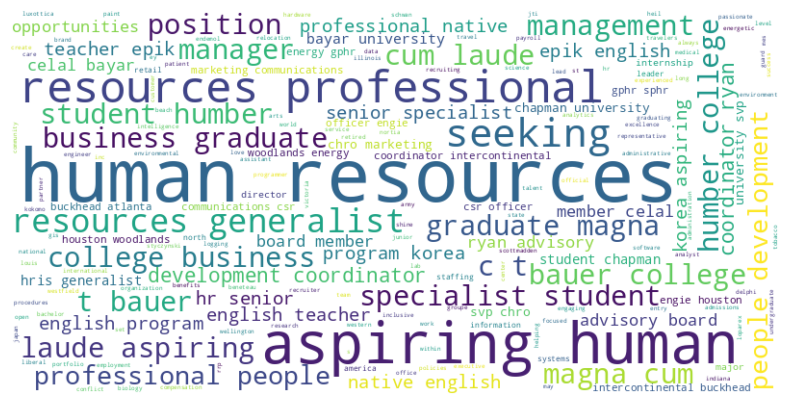

In [147]:
# Visualize the new column as a word cloud
# Combine all job titles into a single string
text = ' '.join(df['job_title_cleaned'])
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axes
plt.show()

It looks as the Word Cloud visualization highlights key terms such as "aspiring", "manager", "human resources" etc., as the most frequently occuring words. This aligns with what the initial keywords were ("Aspiring human resources" & "seeking human resources"). However, some words like "magna", "laude", "epik" appear which are associated with university honours or institution names.

While these reflect academic achievements or affiliations, they may not be directly relevant to identifying the most talented candidates purely based on their professional capabilities. University reputation or a business degree from college could play an important role in candidate evaluation however not all rows or job titles given contain that information. Thus, filtering based on these solely might overlook other strong contenders who have identified themselves as "aspiring HR professionals". But based on what the user searches, these terms will be helpful in distinguishing the requested candidates using cosine similarity etc.

### TF-IDF (Term Frequency-Inverse Document Frequency)

This is a statistical technique used to evaluate the importance of a word in a document relative to a collection of documents (or a corpus).

TF = # Times the term appears in document / # Terms in the document

IDF = Log (Total Documents / Number of Documents containing the term)

Tf-IDF = Tf x IDF

This helps to assign a weight to each term and highlight words that are meaningful and relevant for a given document. This can help to identify the most significant words in candidates' job titles or descriptions.

The above will calculate TF-IDF score for each word based on:
1. How frequent the word is in the specific sentence or document
2. How rare the word is across the entire dataset.

The first step would be to tokenize the text however with TF-IDF libraries such as TfidfVectorizer from sklearn, this is automatically handled for us.

For each job title, we will calculate the TF-IDF vector and then afterward, represent each job title as its corresponding vector in the matrix. We will store that as a new column in our dataframe e.g., df['job_title_vectorized]'

We also require location enabled search so we will combine job_title & location into a single column, compute TF-IDF, and then use that for similarity calculation.

In [148]:
# Clean the location column

df['location_cleaned'] = df['location'].str.lower().str.replace('[^\w\s]', '', regex=True)

# Combine job_title and location into a single column

df['combined_text'] = df['job_title'] + " " + df['location_cleaned']


# Initialize a new TfidfVectorizer for combined text
tfidf_vectorizer_combined = TfidfVectorizer()
tfidf_matrix_combined = tfidf_vectorizer_combined.fit_transform(df['combined_text'])

# Convert the TF-IDF matrices to lists for DataFrame storage
tfidf_values_job_title_location = tfidf_matrix_combined.toarray().tolist()


# Add new columns to store TF-IDF values
df['tfidf_values_combined'] = tfidf_values_job_title_location

# Display the DataFrame with the new columns
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned,location_cleaned,combined_text,tfidf_values_combined
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t . bauer college business graduate ( m...,houston texas,2019 C.T. Bauer College of Business Graduate (...,"[0.3006376441281749, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik ( english program ...,canada,Native English Teacher at EPIK (English Progra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional,raleighdurham north carolina area,Aspiring Human Resources Professional raleighd...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan,denton texas,People Development Coordinator at Ryan denton ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university,izmir türkiye,Advisory Board Member at Celal Bayar Universit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Cosine Similarity

Cosine Similarity is a metric used to measure similarity between two vectors by calculating the cosine of the angle between them in high-dimensional space.

Cosine Similarity Values Range from:
* +1 - Perfectly Similar
* 0 - No similarity
* -1 - Perfectly dissimilar.

Formula:

Cosine Similarity = A . B / ||A|| ||B||

It is used for text & document similarity as it measures the degree of similarity between text vectors helping in ranking, clustering, and matching text data. It is also computationally efficient & works well with sparse data.



Now that we have vectorized our job_title_location combined column, let us convert our query to a vector, then use cosine similarity and use the connections_numeric column to get the most relevant results. We will populate the 'fit' column with our cosine similarity values.

In [153]:
# Define functions that can tokenize & vectorize the query,
# perform cosine similarity, and output the relevant results.


# Additionally, at the end, will also sort the results by number of connections
# in descending order as we would prefer someone well connected and talented.

# Preprocess the query (e.g., lowercase, remove stop words)
def preprocess_query(query):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word.lower() for word in word_tokenize(query) if word.lower() not in stop_words])

# Function to process query, compute cosine similarity, and return top results
def get_top_matches(query, tfidf_vectorizer, tfidf_matrix_combined, df, top_n=10):
    # Preprocess the query
    query_cleaned = preprocess_query(query)

    # Transform the query into vectors for both job_title and location
    query_vector_combined = tfidf_vectorizer.transform([query_cleaned])


    # Compute cosine similarity between the query vector and all job titles
    similarity_scores = cosine_similarity(query_vector_combined, tfidf_matrix_combined).flatten()

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [154]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches(query, tfidf_vectorizer_combined, tfidf_matrix_combined, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): Aspiring HR

Top Matches:
                                    job_title  \
7                        HR Senior Specialist   
25                       HR Senior Specialist   
37                       HR Senior Specialist   
50                       HR Senior Specialist   
60                       HR Senior Specialist   
82  HR Manager at Endemol Shine North America   
2       Aspiring Human Resources Professional   
16      Aspiring Human Resources Professional   
20      Aspiring Human Resources Professional   
32      Aspiring Human Resources Professional   

                               location connection       fit  
7                San Francisco Bay Area      500+   0.353966  
25               San Francisco Bay Area      500+   0.353966  
37               San Francisco Bay Area      500+   0.353966  
50               San Francisco Bay Area      500+   0.353966  
60               San Francisco Bay Area      500+   0.353966  
82    

**Observations:** The above works correctly when the query is very specific however, it cannot recognize HR being Human Resources so when I query Aspiring HR, it returns HR Specialist as a top result but when I write the whole words, the result works as expected.



1.   The above is a common limitation of the TF-IDF approach in its ability to recognize that abbreviations like HR correspond to Human Resources. This occurs due to the fact that TF-IDF treats each term as distinct and lacks the semantic understanding to link abbreviations to their full forms.
2.   Term Independence results in TF-IDF not understanding relationships between terms & their contextual usage.

To solve this, we can use Word Embeddings models such as Word2Vec, GloVe to generate dense vector representation of words, capturing semantic relationships.

Additionally, transformer-based models like BERT can understand context better and capture meanings of phrases and abbreviations within their usage.


#### Re-rank candidates when a candidate is starred

After the user "stars" or selects a candidate, they signal that this candidate is an **ideal match** therefore, the system can use this supervisory signal to adjust the ranking, prioritizing candidates that are similar to the starred candidate. This re-ranking process ensures that future results will reflect the qualities of the starred candidate.

To implement this re-ranking mechanism, we perform initial search as usual, once a user stars a candidate, we can treat this candidate's TF-IDF or semantic embedding as a new benchmark. Using this vector, we compute cosine similarity between the starred candidate's vector and all other candidate's vectors.

Then, we re-rank the list based on the new similarity scores and display the updated list to the user.

Below is the updated implementation of searhing relevant candidates now incorporating re-ranking functionality.

In [155]:
def rerank_candidates(starred_vector, tfidf_matrix, df):
    """Re-rank candidates based on similarity to the starred candidate."""
    # Compute cosine similarity between starred vector and all others
    similarities = cosine_similarity(starred_vector, tfidf_matrix).flatten()

    # Add similarity scores to the DataFrame
    df['fit'] = similarities

    # Sort by similarity score in descending order
    df_sorted = df.sort_values(by='fit', ascending=False)

    # Return the re-ranked DataFrame
    return df_sorted[['job_title', 'location', 'fit']]


while True:
    # Get user input
    query = input("Enter your search query (or type 'exit' to quit): ").strip()
    if query.lower() == 'exit':
        print("Exiting the search.")
        break

    # Call the function to get top matches
    top_results = get_top_matches(query, tfidf_vectorizer_combined, tfidf_matrix_combined, df)

    # Display the top results
    print("\nTop Matches:")
    print(top_results)

    while True:
        try:
            # Ask user to star a candidate from the displayed results
            star_input = input("\nEnter the index of the candidate you want to star (or type 'back' to perform another search): ").strip()
            if star_input.lower() == 'back':
                print("Returning to search...")
                break

            # Convert the input to an integer (index in the DataFrame)
            star_index = int(star_input)

            if star_index < 0 or star_index >= len(top_results):
                print(f"Invalid index. Please select an index between 0 and {len(top_results) - 1}.")
                continue

            # Get the vector of the starred candidate
            starred_vector = tfidf_matrix_combined[top_results.index[star_index]]

            # Re-rank the candidates based on similarity to the starred candidate
            re_ranked_results = rerank_candidates(starred_vector, tfidf_matrix_combined, df)

            # Display the re-ranked results
            print("\nRe-Ranked Results Based on Your Starred Candidate:")
            print(re_ranked_results.head(10))  # Show top 10 results after re-ranking

        except ValueError:
            print("Invalid input. Please enter a valid index or 'back' to perform another search.")

Enter your search query (or type 'exit' to quit): Aspiring Human Resources

Top Matches:
                                            job_title  \
72  Aspiring Human Resources Manager, seeking inte...   
2               Aspiring Human Resources Professional   
16              Aspiring Human Resources Professional   
20              Aspiring Human Resources Professional   
32              Aspiring Human Resources Professional   
45              Aspiring Human Resources Professional   
57              Aspiring Human Resources Professional   
96              Aspiring Human Resources Professional   
6   Student at Humber College and Aspiring Human R...   
8   Student at Humber College and Aspiring Human R...   

                               location connection       fit  
72                  Houston, Texas Area          7  0.479359  
2   Raleigh-Durham, North Carolina Area         44  0.412571  
16  Raleigh-Durham, North Carolina Area         44  0.412571  
20  Raleigh-Durham, North Carol

The above works as expected where once I selected the 6th candidate where the location was North Carolina, in my updated re-ranked list, all top candidates with the same job title keywords and location show up as the top results, thus having 100% fit as shown.

Now the next step will be to experiment with other vector embedding techniques such as Word2Vec, BERT, and additionally open-source LLMs.